# Nuclear ANN 

### Load and preprocess data

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf

data = pd.read_csv('C:/Users/Avishai/Desktop/Senior-project/Ml/getData/combined_fuel_weather_data.csv')
data = data.fillna(0)
data['BeginDate'] = pd.to_datetime(data['BeginDate']).dt.tz_localize(None)
data["Sum"] = data[["Coal", "Hydro", "Natural Gas", "Nuclear", "Oil", "Other", "Landfill Gas", "Refuse", "Solar", "Wind", "Wood"]].sum(axis=1)
data['Previous_Day'] = data['BeginDate'] - pd.Timedelta(days=1)
data['Previous_2Day'] = data['BeginDate'] - pd.Timedelta(days=2)
data['Previous_Year'] = data['BeginDate'] - pd.DateOffset(years=1)
wind_data = data[['BeginDate', 'Nuclear','Previous_Day','Previous_Year','Previous_2Day']].copy()


C:\Users\Avishai\AppData\Local\Temp\ipykernel_56516\3507193380.py:6: DtypeWarning: Columns (12,17) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('C:/Users/Avishai/Desktop/Senior-project/Ml/getData/combined_fuel_weather_data.csv')


In [2]:
from bisect import bisect_left

def get_previous_day_Wind(row, reference_df):
    # Sort reference_df by 'BeginDate' for fast lookups
    sorted_dates = reference_df['BeginDate'].values
    solar_values = reference_df['Nuclear'].values
    
    # Perform binary search to find the index of the closest date
    target_date = row['Previous_Day']
    pos = bisect_left(sorted_dates, target_date)
    
    # Find the closest date and return corresponding Solar value
    if pos == 0:
        return solar_values[0]
    if pos == len(sorted_dates):
        return solar_values[-1]
    
    before = sorted_dates[pos - 1]
    after = sorted_dates[pos]
    
    # Return the Solar value corresponding to the closest date
    if abs(target_date - before) <= abs(target_date - after):
        return solar_values[pos - 1]
    else:
        return solar_values[pos]

In [3]:
from bisect import bisect_left

def get_two_days_before_Wind(row, reference_df):
    # Sort reference_df by 'BeginDate' for fast lookups
    sorted_dates = reference_df['BeginDate'].values
    solar_values = reference_df['Nuclear'].values
    
    # Calculate two days before
    target_date = row['BeginDate'] - pd.Timedelta(days=2)
    
    # Perform binary search to find the index of the closest date
    pos = bisect_left(sorted_dates, target_date)
    
    # Find the closest date and return corresponding Solar value
    if pos == 0:
        return solar_values[0]
    if pos == len(sorted_dates):
        return solar_values[-1]
    
    before = sorted_dates[pos - 1]
    after = sorted_dates[pos]
    
    # Return the Solar value corresponding to the closest date
    if abs(target_date - before) <= abs(target_date - after):
        return solar_values[pos - 1]
    else:
        return solar_values[pos]


In [4]:
from bisect import bisect_left

def get_previous_year_Wind(row, reference_df):
    # Sort reference_df by 'BeginDate' for fast lookups
    sorted_dates = reference_df['BeginDate'].values
    solar_values = reference_df['Nuclear'].values
    
    # Perform binary search to find the index of the closest date
    target_date = row['Previous_Year']
    pos = bisect_left(sorted_dates, target_date)
    
    # Find the closest date and return corresponding Solar value
    if pos == 0:
        return solar_values[0]
    if pos == len(sorted_dates):
        return solar_values[-1]
    
    before = sorted_dates[pos - 1]
    after = sorted_dates[pos]
    
    # Return the Solar value corresponding to the closest date
    if abs(target_date - before) <= abs(target_date - after):
        return solar_values[pos - 1]
    else:
        return solar_values[pos]


In [5]:
# Large computation 
data['Previous_Year_Nuclear'] = data.apply(get_previous_year_Wind, axis=1, reference_df=wind_data)

In [30]:
cutoff_date = pd.to_datetime("2024-11-13").tz_localize(None)
usable_data = data[data['BeginDate'] > cutoff_date].copy()
solar_data2 = usable_data[['BeginDate', 'Nuclear','Previous_Day','Previous_2Day','Previous_Year']].copy()

In [31]:


usable_data['Previous_Day_Nuclear'] = usable_data.apply(get_previous_day_Wind, axis=1, reference_df=solar_data2)
usable_data['Previous_2Day_Nuclear'] = usable_data.apply(get_two_days_before_Wind, axis=1, reference_df=solar_data2)


In [32]:
usable_data['Hour_of_Day'] = usable_data['BeginDate'].dt.hour
usable_data['Year'] = usable_data['BeginDate'].dt.year
usable_data['Month'] = usable_data['BeginDate'].dt.month
usable_data['Day'] = usable_data['BeginDate'].dt.day
features = usable_data[['Month','Day','Previous_2Day_Nuclear','Sum','Hour_of_Day']]


# Useless Features , , 
target = usable_data['Nuclear']

print("Features shape: ", features.shape)
print('Target shape: ', target.shape)

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

scalar = StandardScaler()
X_train = scalar.fit_transform(X_train)
X_test = scalar.transform(X_test)

Features shape:  (1253, 5)
Target shape:  (1253,)


In [36]:
from tensorflow.keras import regularizers
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])

model.compile(optimizer='adam', loss='mean_absolute_error')

history = model.fit(X_train, y_train, epochs=450, validation_split=0.15, batch_size=128)

test_loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}')

Epoch 1/450


C:\Users\Avishai\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 3035.7710 - val_loss: 3058.2351
Epoch 2/450
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3025.1484 - val_loss: 3057.6157
Epoch 3/450
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3022.6736 - val_loss: 3056.6677
Epoch 4/450
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3026.4434 - val_loss: 3055.1768
Epoch 5/450
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3026.7307 - val_loss: 3052.8296
Epoch 6/450
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3023.9976 - val_loss: 3049.1882
Epoch 7/450
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 3029.1018 - val_loss: 3043.6555
Epoch 8/450
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3019.0984 - val_loss: 3035.5356
Epoch 9/450
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2999.2405 - val_loss: 3023.9463
Epoch 10/450
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 2982.2581 - val_loss: 3007.7422
Epoch 11/450
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2971.4336 - val_loss: 2985.6355
Epoch 12/450
7/7 ━━━━━━━━━━━

### Analysis

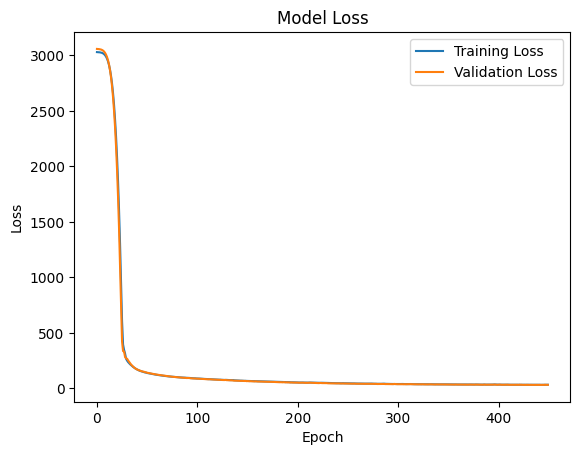

In [37]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

### Make predictions

In [38]:
import numpy as np
predictions = model.predict(X_test)
predictions[predictions < 0] = 0
flattened_predictions = [0 if (isinstance(pred, np.ndarray) and pred.item() < 0) else (0 if pred < 0 else pred.item() if isinstance(pred, np.ndarray) else pred) for pred in predictions]

print(f'Predicted Solar Energy Ouput: {flattened_predictions[:20]}')
print(f'Actual Solar Energy Output: {y_test[:20].values}')


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
Predicted Solar Energy Ouput: [3335.52783203125, 3355.267822265625, 3347.593017578125, 3342.363525390625, 3343.494384765625, 3344.759765625, 3349.073486328125, 3366.343994140625, 3366.574462890625, 2982.679931640625, 3333.431884765625, 3338.443603515625, 3349.204345703125, 2627.982666015625, 3070.062744140625, 3375.813720703125, 3378.993408203125, 2467.5107421875, 2470.574951171875, 2998.554443359375]
Actual Solar Energy Output: [3346. 3353. 3351. 3345. 3347. 3344. 3332. 3347. 3346. 2926. 3345. 3345.
 3340. 2630. 3106. 3328. 3349. 2473. 2469. 2979.]


In [39]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Assuming predictions and y_test are numpy arrays or pandas series
# predictions = model.predict(X_test)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, predictions)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, predictions)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
average_y_test = np.mean(y_test)
percent_error = mae / average_y_test

# Display results
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Percent Error (PERR): {percent_error}")

Mean Absolute Error (MAE): 29.317767017866036
Mean Squared Error (MSE): 3872.53208233612
Root Mean Squared Error (RMSE): 62.22967204104582
Percent Error (PERR): 0.00969361117783316


### Save model

In [40]:
model.save('NuclearModel.h5')